### This example demonstrates the XCSF multi-step reinforcement learning mechanisms
Discrete mazes are loaded from a specified input file.

In [1]:
from __future__ import annotations

import json
import os
import random
import sys
from typing import Final

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import xcsf

RANDOM_STATE: Final[int] = 1
random.seed(RANDOM_STATE)

### Create maze problem class

In [2]:
class Maze:
    """
    Maze problem environment.

    The maze class reads in the chosen maze from a file where each entry
    specifies a distinct position in the maze. The maze is toroidal and if the
    agent/animat reaches one edge it can reenter the maze from the other side.
    Obstacles are coded as 'O' and 'Q', empty positions as '*', and food as 'F'
    or 'G'. The 8 adjacent cells are perceived by the animat and 8 movements
    are possible to one of the adjacent cells (if not blocked.) The animat is
    initially placed at a random empty position. The goal is to find the
    shortest path to the food.

    Some mazes require a form of memory to be solved optimally.
    """

    OPTIMAL: Final[dict] = {
        "woods1": 1.7,
        "woods2": 1.7,
        "woods14": 9.5,
        "maze4": 3.5,
        "maze5": 4.61,
        "maze6": 5.19,
        "maze7": 4.33,
        "maze10": 5.11,
        "woods101": 2.9,
        "woods101half": 3.1,
        "woods102": 3.31,
        "mazef1": 1.8,
        "mazef2": 2.5,
        "mazef3": 3.375,
        "mazef4": 4.5,
    }
    MAX_PAYOFF: Final[float] = 1  #: reward for finding the goal
    X_MOVES: Final[list[int]] = [0, 1, 1, 1, 0, -1, -1, -1]  #: x-axis moves
    Y_MOVES: Final[list[int]] = [-1, -1, 0, 1, 1, 1, 0, -1]  #: y-axis moves

    def __init__(self, filename: str) -> None:
        """Constructs a new maze problem."""
        self.name: Final[str] = filename  #: maze name
        self.maze: list[list[str]] = []  #: maze as read from the input file
        line: list[str] = []
        path = os.path.normpath("../../env/maze/" + filename + ".txt")
        with open(path) as f:
            while True:
                c = f.read(1)
                if not c:
                    break
                if c == "\n":
                    self.maze.insert(0, line)
                    line = []
                else:
                    line.append(c)
        self.x_size: Final[int] = len(self.maze[0])  #: maze width
        self.y_size: Final[int] = len(self.maze)  #: maze height
        self.state: np.ndarray = np.zeros(8)  #: current maze state
        self.x_pos: int = 0  #: current x position within the maze
        self.y_pos: int = 0  #: current y position within the maze

    def reset(self) -> np.ndarray:
        """Resets a maze problem: generating a new random start position."""
        while True:
            self.x_pos = random.randint(0, self.x_size - 1)
            self.y_pos = random.randint(0, self.y_size - 1)
            if self.maze[self.y_pos][self.x_pos] == "*":
                break
        self.update_state()
        return np.copy(self.state)

    def sensor(self, x_pos: int, y_pos: int) -> float:
        """Returns the real-number representation of a discrete maze cell."""
        s: Final[str] = self.maze[y_pos][x_pos]
        if s == "*":
            return 0.1
        if s == "O":
            return 0.3
        if s == "Q":
            return 0.4
        if s == "G":
            return 0.7
        if s == "F":
            return 0.9
        print(f"invalid maze state: {s}")
        sys.exit()

    def update_state(self) -> None:
        """Sets the state to a real-vector representing the sensory input."""
        spos: int = 0
        for i in range(-1, 2):
            for j in range(-1, 2):
                if j == 0 and i == 0:
                    continue
                x = ((self.x_pos + j) % self.x_size + self.x_size) % self.x_size
                y = ((self.y_pos + i) % self.y_size + self.y_size) % self.y_size
                self.state[spos] = self.sensor(x, y)
                spos += 1

    def step(self, act: int) -> tuple[np.ndarray, float, bool]:
        """
        Takes a step in the maze, performing the specified action.
        Returns next state, immediate reward and whether terminal state reached.
        """
        if act < 0 or act > 7:
            print("invalid maze action")
            sys.exit()
        x_vec: Final[int] = Maze.X_MOVES[act]
        y_vec: Final[int] = Maze.Y_MOVES[act]
        x_new: int = ((self.x_pos + x_vec) % self.x_size + self.x_size) % self.x_size
        y_new: int = ((self.y_pos + y_vec) % self.y_size + self.y_size) % self.y_size
        s: Final[str] = self.maze[y_new][x_new]
        if s in ("O", "Q"):
            return np.copy(self.state), 0, False
        self.x_pos = x_new
        self.y_pos = y_new
        self.update_state()
        if s == "*":
            return np.copy(self.state), 0, False
        if s in ("F", "G"):
            return np.copy(self.state), self.max_payoff(), True
        print("invalid maze type")
        sys.exit()

    def optimal(self) -> float:
        """Returns the optimal number of steps to the goal."""
        return Maze.OPTIMAL[self.name]

    def max_payoff(self) -> float:
        """Returns the reward for reaching the goal state."""
        return float(Maze.MAX_PAYOFF)

    def display(self) -> None:
        """Prints the maze problem."""
        for row in maze.maze:
            print(*row, sep="")

### Instantiate a new maze problem

In [3]:
maze: Maze = Maze("maze4")

In [4]:
maze.display()

OOOOOOOO
O****O*O
OO*O***O
O******O
OO*O**OO
OO**O**O
O**O**FO
OOOOOOOO


In [5]:
print(f"Optimal (average) number of steps to goal: {maze.optimal()}")

Optimal (average) number of steps to goal: 3.5


In [6]:
print(f"Reward for reaching the goal: {maze.max_payoff()}")

Reward for reaching the goal: 1.0


### Initialise XCSF

In [7]:
PERF_TRIALS: Final[float] = 50  # display frequency
TELETRANSPORTATION: Final[int] = 50  # reset after this many steps

xcs = xcsf.XCS(
    x_dim=8,
    y_dim=1,
    n_actions=8,
    alpha=0.1,
    beta=0.2,
    delta=0.1,
    e0=0.001,
    init_error=0,
    init_fitness=0.01,
    m_probation=10000,
    nu=5,
    omp_num_threads=12,
    perf_trials=PERF_TRIALS,
    pop_init=False,
    pop_size=1000,
    random_state=RANDOM_STATE,
    set_subsumption=True,
    theta_del=50,
    theta_sub=100,
    ea={
        "select_type": "roulette",
        "theta_ea": 50,
        "lambda": 2,
        "p_crossover": 0.8,
        "err_reduc": 1,
        "fit_reduc": 0.1,
        "subsumption": True,
        "pred_reset": False,
    },
    action={
        "type": "integer",
    },
    condition={
        "type": "ternary",
        "args": {
            "bits": 2,
        },
    },
    prediction={
        "type": "rls_linear",
    },
)

print(json.dumps(xcs.get_params(), indent=4))

{
    "version": "1.3.0",
    "x_dim": 8,
    "y_dim": 1,
    "n_actions": 8,
    "omp_num_threads": 12,
    "random_state": 1,
    "population_file": "",
    "pop_init": false,
    "max_trials": 100000,
    "perf_trials": 50,
    "pop_size": 1000,
    "loss_func": "mae",
    "set_subsumption": true,
    "theta_sub": 100,
    "e0": 0.001,
    "alpha": 0.1,
    "nu": 5,
    "beta": 0.2,
    "delta": 0.1,
    "theta_del": 50,
    "init_fitness": 0.01,
    "init_error": 0,
    "m_probation": 10000,
    "stateful": true,
    "compaction": false,
    "ea": {
        "select_type": "roulette",
        "theta_ea": 50,
        "lambda": 2,
        "p_crossover": 0.8,
        "err_reduc": 1,
        "fit_reduc": 0.1,
        "subsumption": true,
        "pred_reset": false
    },
    "condition": {
        "type": "ternary",
        "args": {
            "bits": 2
        }
    },
    "prediction": {
        "type": "rls_linear"
    },
    "action": {
        "type": "integer"
    }
}


### Execute experiment

In [8]:
N: Final[int] = 40  # 2,000 trials
trials: np.ndarray = np.zeros(N)
psize: np.ndarray = np.zeros(N)
msize: np.ndarray = np.zeros(N)
steps: np.ndarray = np.zeros(N)
error: np.ndarray = np.zeros(N)


def trial(env: Maze, explore: bool) -> tuple[int, float]:
    """Executes a single trial/episode."""
    err: float = 0
    cnt: int = 0
    state: np.ndarray = env.reset()
    xcs.init_trial()
    while cnt < TELETRANSPORTATION:
        xcs.init_step()
        action = xcs.decision(state, explore)
        next_state, reward, done = env.step(action)
        xcs.update(reward, done)
        err += xcs.error(reward, done, env.max_payoff())
        xcs.end_step()
        cnt += 1
        if done:
            break
        state = next_state
    xcs.end_trial()
    return cnt, err / cnt


def run_experiment(env: Maze) -> None:
    """Executes a single experiment."""
    bar = tqdm(total=N)  # progress bar
    for i in range(N):
        for _ in range(PERF_TRIALS):
            trial(env, True)  # explore
            cnt, err = trial(env, False)  # exploit
            steps[i] += cnt
            error[i] += err
        steps[i] /= float(PERF_TRIALS)
        error[i] /= float(PERF_TRIALS)
        trials[i] = (i + 1) * PERF_TRIALS
        psize[i] = xcs.pset_size()  # current population size
        msize[i] = xcs.mset_size()  # avg match set size
        status = (  # update status
            f"trials={trials[i]:.0f} "
            f"steps={steps[i]:.2f} "
            f"error={error[i]:.5f} "
            f"psize={psize[i]:.1f} "
            f"msize={msize[i]:.1f}"
        )
        bar.set_description(status)
        bar.refresh()
        bar.update(1)
    bar.close()


run_experiment(maze)

trials=2000 steps=3.66 error=0.00013 psize=824.0 msize=212.1: 100%|████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.11it/s]


### Plot learning performance

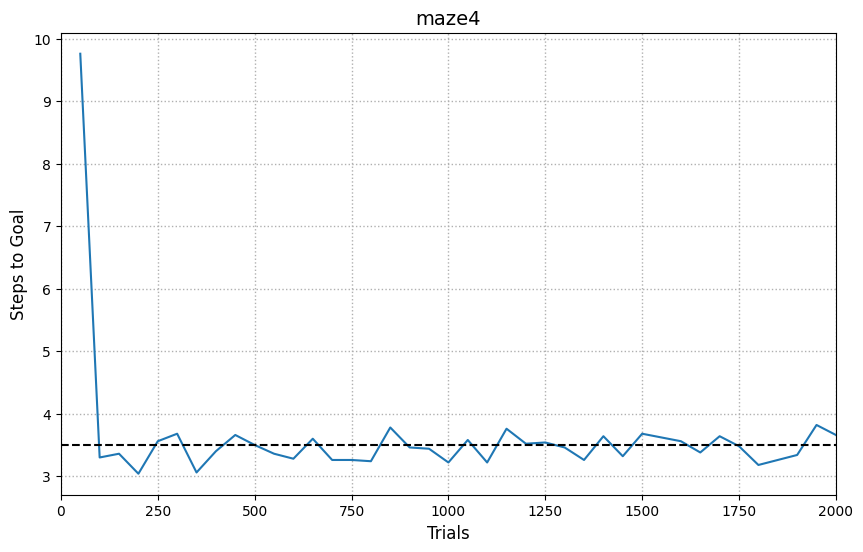

In [9]:
def plot_performance(env: Maze):
    """Plots learning performance."""
    plt.figure(figsize=(10, 6))
    plt.plot(trials, steps)
    plt.grid(linestyle="dotted", linewidth=1)
    plt.axhline(y=env.optimal(), xmin=0, xmax=1, linestyle="--", color="k")
    plt.title(env.name, fontsize=14)
    plt.ylabel("Steps to Goal", fontsize=12)
    plt.xlabel("Trials", fontsize=12)
    plt.xlim([0, N * PERF_TRIALS])
    plt.show()


plot_performance(maze)

### Visualise some runs

Press enter to exit.


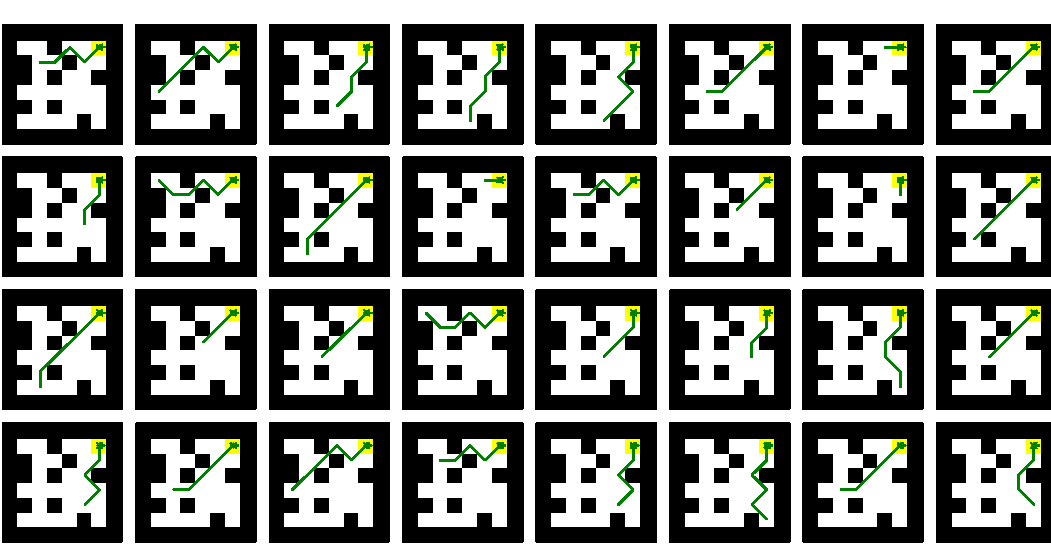

In [10]:
import io
from PIL import Image
from turtle import Screen, Turtle
from IPython.display import display

GRID_WIDTH: Final[int] = maze.x_size
GRID_HEIGHT: Final[int] = maze.y_size
CELL_SIZE: Final[int] = 20
WIDTH: Final[int] = 1400
HEIGHT: Final[int] = 720
screen = Screen()
screen.setup(WIDTH + 4, HEIGHT + 8)
screen.setworldcoordinates(0, 0, WIDTH, HEIGHT)


def draw_maze(xoff: int, yoff: int) -> None:
    """Draws the background and outline of the current maze."""
    bg = Turtle(visible=False)
    screen.tracer(False)
    bg.penup()
    bg.speed("fastest")
    bg.shape("square")
    bg.shapesize(1, 1)
    for y in range(maze.y_size):
        for x in range(maze.x_size):
            s = maze.maze[y][x]
            if s == "*":
                bg.color("white")
            if s == "O":
                bg.color("black")
            if s == "G":
                bg.color("yellow")
            if s == "F":
                bg.color("yellow")
            if s == "Q":
                bg.color("brown")
            bg.goto(xoff + x * CELL_SIZE, yoff + y * CELL_SIZE)
            bg.stamp()
    xoff = round(xoff - CELL_SIZE / 2)
    yoff = round(yoff - CELL_SIZE / 2)
    bg.goto(xoff, yoff)
    bg.pensize(2)
    bg.color("black")
    bg.pendown()
    bg.goto(xoff, yoff + GRID_HEIGHT * CELL_SIZE)
    bg.goto(xoff + GRID_WIDTH * CELL_SIZE, yoff + GRID_HEIGHT * CELL_SIZE)
    bg.goto(xoff + GRID_WIDTH * CELL_SIZE, yoff)
    bg.goto(xoff, yoff)
    bg.penup()


def visualise(xoff: int, yoff: int) -> None:
    """Executes an XCSF exploit run through the maze and draws the path."""
    state: np.ndarray = maze.reset()
    agent = Turtle(visible=True)
    agent.shape("turtle")
    agent.color("green")
    agent.speed("fastest")
    agent.shapesize(0.5, 0.5)
    agent.pensize(2)
    agent.penup()
    agent.goto(xoff + maze.x_pos * CELL_SIZE, yoff + maze.y_pos * CELL_SIZE)
    agent.pendown()
    agent.speed("normal")
    screen.tracer(True)
    xcs.init_trial()
    for _ in range(TELETRANSPORTATION):
        xcs.init_step()
        action = xcs.decision(state, False)
        next_state, reward, done = maze.step(action)
        agent.goto(xoff + maze.x_pos * CELL_SIZE, yoff + maze.y_pos * CELL_SIZE)
        xcs.update(reward, done)
        xcs.end_step()
        if done:
            break
        state = next_state
    xcs.end_trial()


def draw_runs() -> None:
    """Draw some runs through the maze."""
    grid_xoff: Final[int] = GRID_WIDTH * CELL_SIZE
    grid_yoff: Final[int] = GRID_HEIGHT * CELL_SIZE
    for i in range(8):
        for j in range(4):
            xoff = i * (grid_xoff + CELL_SIZE)
            yoff = j * (grid_yoff + CELL_SIZE)
            draw_maze(xoff, yoff)
            visualise(xoff, yoff)


draw_runs()

# save as png involves converting from ghostscript
ps = screen.getcanvas().postscript(colormode="color")
im = Image.open(io.BytesIO(ps.encode("utf-8")))
im.save("maze_runs.png", format="png")
im = Image.open("maze_runs.png")

input("Press enter to exit.")

# display final plot
display(im)

# close out turtle
screen.bye()